In [1]:
import os
import numpy as np
import pandas as pd

In [7]:
%pwd

'/Users/mengmeng/bootcamp_Shuchen_Meng/homework/homework7'

In [8]:
RAW_PATH = "data/raw/outliers_homework.csv" 

In [9]:
def make_synthetic_df(seed=7):
    np.random.seed(seed)
    x = np.linspace(0, 10, 60)
    y = 1.8 * x + 0.5 + np.random.normal(0, 1.8, size=x.size)
    # 注入离群点（与你的代码保持一致）
    y[8]  += 20
    y[25] -= 18
    y[47] += 15
    return pd.DataFrame({"x": x, "y": y})

if os.path.exists(RAW_PATH):
    df = pd.read_csv(RAW_PATH)
    print("Loaded provided dataset from", RAW_PATH)
else:
    print("CSV not found; generating synthetic fallback and saving to", RAW_PATH)
    df = make_synthetic_df()
    os.makedirs(os.path.dirname(RAW_PATH), exist_ok=True)
    df.to_csv(RAW_PATH, index=False)

df.head()

CSV not found; generating synthetic fallback and saving to data/raw/outliers_homework.csv


,x,y
0,0.000000,3.542946
1,0.169492,-0.033603
2,0.338983,1.169246
3,0.508475,2.148784
4,0.677966,0.300278


In [10]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask where True indicates an outlier by IQR rule.
    Parameters
    ----------
    series : pd.Series
        Numeric series to evaluate.
    k : float
        Multiplier for IQR to set fences (default 1.5).
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

df['outlier_iqr'] = detect_outliers_iqr(df['y'])
df['outlier_iqr'].value_counts()

outlier_iqr
False    58
True      2
Name: count, dtype: int64

In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [16]:
%pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


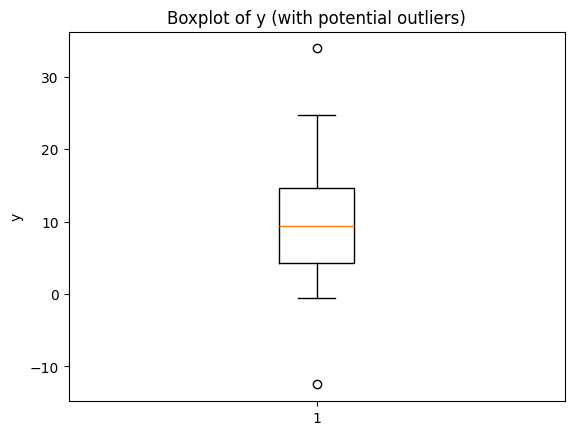

In [18]:
plt.figure()
plt.boxplot(df['y'], vert=True)
plt.title('Boxplot of y (with potential outliers)')
plt.ylabel('y')
plt.show()

In [19]:
def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask where True indicates |z| > threshold."""
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

df['outlier_z'] = detect_outliers_zscore(df['y'], threshold=3.0)
pd.crosstab(df['outlier_iqr'], df['outlier_z'])

outlier_z,False,True
outlier_iqr,,
False,58,0
True,0,2


In [21]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    if not (0.0 <= lower < upper <= 1.0):
        raise ValueError(f"Invalid quantile bounds: lower={lower}, upper={upper}. Must satisfy 0 <= lower < upper <= 1.")

    # Ensure Series
    s = pd.Series(series).copy()

    # Try to ensure numeric; non-numeric becomes NaN
    if not np.issubdtype(s.dtype, np.number):
        s = pd.to_numeric(s, errors="coerce")

    # If all NaN or empty, just return
    if s.dropna().empty:
        return s

    # Compute quantile caps (NaNs automatically ignored by quantile on Series)
    q_low = s.quantile(lower, interpolation="linear")
    q_high = s.quantile(upper, interpolation="linear")

    # If quantiles collapse (e.g., constant series), just return clip (no-op)
    if pd.isna(q_low) or pd.isna(q_high):
        return s

    # Clip to the quantile bounds
    return s.clip(lower=q_low, upper=q_high)


df["y_winsor"] = winsorize_series(df["y"], lower=0.05, upper=0.95)
df.head()

,x,y,outlier_iqr,outlier_z,y_winsor
0,0.000000,3.542946,False,False,3.542946
1,0.169492,-0.033603,False,False,0.283584
2,0.338983,1.169246,False,False,1.169246
3,0.508475,2.148784,False,False,2.148784
4,0.677966,0.300278,False,False,0.300278


In [23]:
def summary_stats(s: pd.Series) -> dict:
    return {"mean": float(s.mean()), "median": float(s.median()), "std": float(s.std())}

y_with = df["y"]
y_without = df.loc[~df["outlier_iqr"], "y"]
y_winsor = df["y_winsor"]

print("Summary WITH outliers :", summary_stats(y_with))
print("Summary WITHOUT outliers:", summary_stats(y_without))
print("Summary WINSORIZED (5%-95%):", summary_stats(y_winsor))

Summary WITH outliers : {'mean': 9.710042426987236, 'median': 9.444204742384, 'std': 7.274870579327088}
Summary WITHOUT outliers: {'mean': 9.67589645668498, 'median': 9.444204742384, 'std': 5.990403445739301}
Summary WINSORIZED (5%-95%): {'mean': 9.583243455402544, 'median': 9.444204742384, 'std': 5.878790806049989}


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

def fit_and_eval(X: pd.DataFrame, y: pd.Series) -> dict:
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return {
        "coef": float(model.coef_[0]),
        "intercept": float(model.intercept_),
        "R2": float(r2_score(y, y_pred)),
        "MAE": float(mean_absolute_error(y, y_pred)),
    }


X_with = df[["x"]]
y_with = df["y"]

X_without = df.loc[~df["outlier_iqr"], ["x"]]
y_without = df.loc[~df["outlier_iqr"], "y"]

# winsorize 情况下 X 不变，但 y 被截顶
y_winsor = y_winsor  

print("Linear Regression — WITH outliers :", fit_and_eval(X_with, y_with))
print("Linear Regression — WITHOUT outliers:", fit_and_eval(X_without, y_without))
print("Linear Regression — WINSORIZED     :", fit_and_eval(X_with, y_winsor))


Linear Regression — WITH outliers : {'coef': 1.797589279550303, 'intercept': 0.7220960292357219, 'R2': 0.5349660376014858, 'MAE': 2.3831441622669947}
Linear Regression — WITHOUT outliers: {'coef': 1.6563116856386055, 'intercept': 1.4572604478762354, 'R2': 0.6806457878480937, 'MAE': 1.8631272421408103}
Linear Regression — WINSORIZED     : {'coef': 1.7114347667068772, 'intercept': 1.0260696218681584, 'R2': 0.7425753075489648, 'MAE': 1.8193699470244988}
